# Tutorial: optimal binning with binary target - large scale

Continuing with the previous tutorial, version 0.4.0 introduced four new ``monotonic_trend``  options: "auto_heuristic", "auto_asc_desc", "peak_heuristic" and "valley_heuristic". These new heuristic options are devised to produce a remarkable speedup for large size instances, at the expense of not guaranteeing optimal solutions (although the optimal solution is found in the majority of cases).

Let's start by loading the training data.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/kaggle/HomeCreditDefaultRisk/application_train.csv", engine='c')

We choose the same variable to discretize and the binary target.

In [3]:
variable = "REGION_POPULATION_RELATIVE"
x = df[variable].values
y = df.TARGET.values

In [4]:
from optbinning import OptimalBinning

We use the same options to generate a granular binning, and fit the optimal binning with ``monotonic_trend="auto"``.

In [5]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp",
                      monotonic_trend="auto", max_n_prebins=100,
                      min_prebin_size=0.001, time_limit=200)

In [6]:
optb.fit(x, y)

OptimalBinning(max_n_prebins=100, min_prebin_size=0.001,
               name='REGION_POPULATION_RELATIVE', time_limit=200)

In [7]:
optb.status

'OPTIMAL'

In [8]:
optb.information(print_level=1)

optbinning (Version 0.18.0)
Copyright (c) 2019-2023 Guillermo Navas-Palencia, Apache License 2.0

  Name    : REGION_POPULATION_RELATIVE      
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of pre-bins                    77
    Number of refinements                  0

  Solver statistics
    Type                                  cp
    Number of booleans                  3148
    Number of branches                120892
    Number of conflicts                34005
    Objective value                    37758
    Best objective bound               37758

  Timing
    Total time                        154.53 sec
    Pre-processing                      0.01 sec   (  0.01%)
    Pre-binning                         0.48 sec   (  0.31%)
    Solver                            154.03 sec   ( 99.68%)
      model generation                 25.98 sec   ( 16.87%)
      optimizer                       128.06 sec   ( 83.13%)
    Post-processing                     0

In [9]:
binning_table = optb.binning_table
binning_table.build()
binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.08180326
    IV (Jeffrey)             0.03776231
    JS (Jensen-Shannon)      0.00465074
    Hellinger                0.00468508
    Triangular               0.01833822
    KS                       0.06087208
    HHI                      0.23425608
    HHI (normalized)         0.16464300
    Cramer's V               0.05102627
    Quality score            0.06257516

  Monotonic trend                  peak

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]     P[B > A]
        0      1     1.445262 2.292897e-01  1.013041e-01 8.986959e-01
        1      2   158.939080 1.929529e-36 1.179082e-218 1.000000e+00
        2      3   131.200666 2.238000e-30  1.000000e+00 1.110223e-16
        3      4     0.878638 3.485750e-01  8.240457e-01 1.759543e-01
        4      5    14.92540

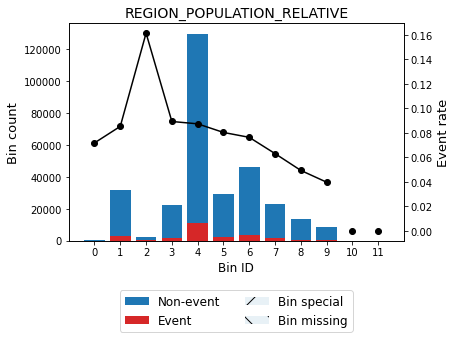

In [10]:
binning_table.plot(metric="event_rate")

This is a large combinatorial problem, and it took roughly 150 seconds... but we can try the ``monotonic_trend="auto_heuristic"`` to accelerate the solution process

In [11]:
optb_auto = OptimalBinning(name=variable, dtype="numerical", solver="cp",
                           monotonic_trend="auto_heuristic", max_n_prebins=100,
                           min_prebin_size=0.001, time_limit=200)

In [12]:
optb_auto.fit(x, y)

OptimalBinning(max_n_prebins=100, min_prebin_size=0.001,
               monotonic_trend='auto_heuristic',
               name='REGION_POPULATION_RELATIVE', time_limit=200)

In [13]:
optb_auto.status

'OPTIMAL'

In [14]:
optb_auto.information(print_level=1)

optbinning (Version 0.18.0)
Copyright (c) 2019-2023 Guillermo Navas-Palencia, Apache License 2.0

  Name    : REGION_POPULATION_RELATIVE      
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of pre-bins                    77
    Number of refinements                  0

  Solver statistics
    Type                                  cp
    Number of booleans                   424
    Number of branches                   874
    Number of conflicts                    9
    Objective value                    37758
    Best objective bound               37758

  Timing
    Total time                          9.77 sec
    Pre-processing                      0.00 sec   (  0.03%)
    Pre-binning                         0.43 sec   (  4.38%)
    Solver                              9.34 sec   ( 95.54%)
      model generation                  8.65 sec   ( 92.58%)
      optimizer                         0.69 sec   (  7.42%)
    Post-processing                     0

In [15]:
binning_table = optb_auto.binning_table
binning_table.build()
binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.08180326
    IV (Jeffrey)             0.03776231
    JS (Jensen-Shannon)      0.00465074
    Hellinger                0.00468508
    Triangular               0.01833822
    KS                       0.06087208
    HHI                      0.23425608
    HHI (normalized)         0.16464300
    Cramer's V               0.05102627
    Quality score            0.06257516

  Monotonic trend                  peak

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]     P[B > A]
        0      1     1.445262 2.292897e-01  1.013041e-01 8.986959e-01
        1      2   158.939080 1.929529e-36 1.179082e-218 1.000000e+00
        2      3   131.200666 2.238000e-30  1.000000e+00 1.110223e-16
        3      4     0.878638 3.485750e-01  8.240457e-01 1.759543e-01
        4      5    14.92540

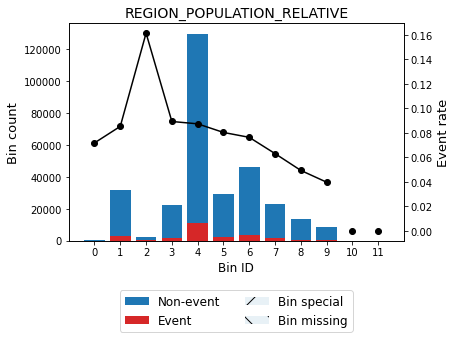

In [16]:
binning_table.plot(metric="event_rate")

For this example, we found the optimal solution with an overall **16x** speedup, where optimization time is reduced by **99%!!**